# Speaker Identification

In [ ]:
!pip install tensorflow==2.8.0
!pip install tensorflow-io==0.25.0

In [2]:
import sys
import os
from pathlib import Path
from typing import Tuple

import tensorflow as tf
import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
print("TensorFlow IO version:", tfio.__version__)

TensorFlow version: 2.8.0
TensorFlow IO version: 0.25.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR='/content/drive/MyDrive/College/Research/Linh_2023_Research'
sys.path.append(ROOT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

<AudioIOTensor: shape=[234241      1], dtype=<dtype: 'int16'>, rate=16000>
tf.Tensor([ 2807  -160   -47 ... -1610 -1197  -358], shape=(234241,), dtype=int16)
tf.Tensor([     4 234232], shape=(2,), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64) tf.Tensor(234232, shape=(), dtype=int64)


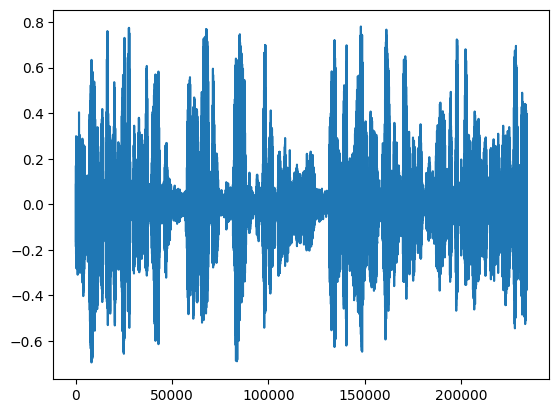

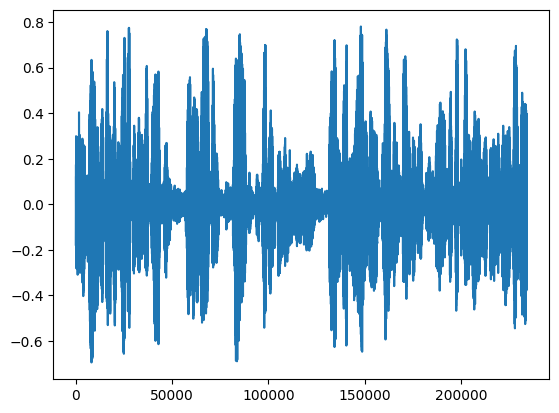

In [47]:
DATA_PATH=ROOT_DIR+'/test_data/vox'
# test_audio_path=DATA_PATH+'/id10004/6WxS8rpNjmk00001.wav'
test_audio_path=DATA_PATH+'/id10004/BOAd7pybyZw00003.wav'

# Read an Audio File
audio = tfio.audio.AudioIOTensor(test_audio_path)
print(audio)

from IPython.display import Audio

audio_tensor = tf.squeeze(audio[:], axis=[-1])
print(audio_tensor)
Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

# Trim the noise
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

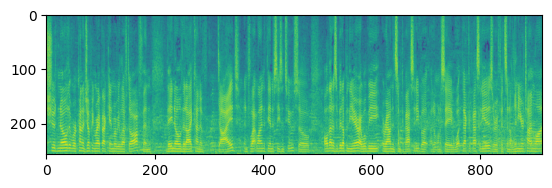

In [52]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    processed, nfft=512, window=512, stride=256)
spectrogram = tf.reverse(spectrogram, axis=[1])
spectrogram = tf.transpose(spectrogram)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())